<a href="https://colab.research.google.com/github/SoungbinC/CMPE294_Assignments/blob/Assignment_timegpt/nixtla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os
os.environ["NIXTLA_API_KEY"] = "nixak-G2WzVRyCuCb6zURfeM3aftmTaLEn1Uu7eL82BSauIt59ujrAogtX93E67ExiZxVy4m62dNLjVtbuKqgT"

#TimeGPT Multivariate and Long Horizon Forecasting Colab

In [30]:
!pip install nixtlats matplotlib pandas
!pip install --upgrade nixtlats
# Install necessary libraries
!pip install nixtlats matplotlib pandas yfinance

Sample data:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


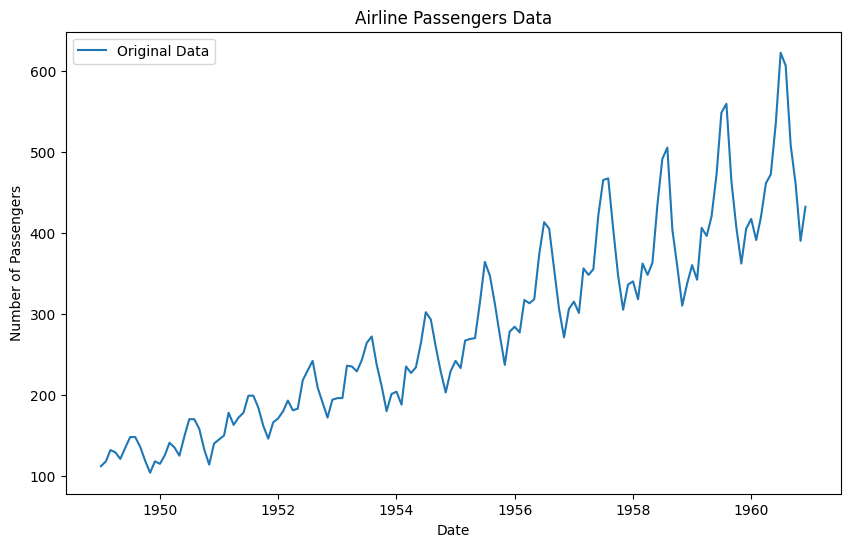

Processed data sample:
            Passengers  Passengers_Scaled       Trend
Month                                                
1949-01-01         112              0.112  112.000000
1949-02-01         118              0.118  115.000000
1949-03-01         132              0.132  120.666667
1949-04-01         129              0.129  122.750000
1949-05-01         121              0.121  122.400000


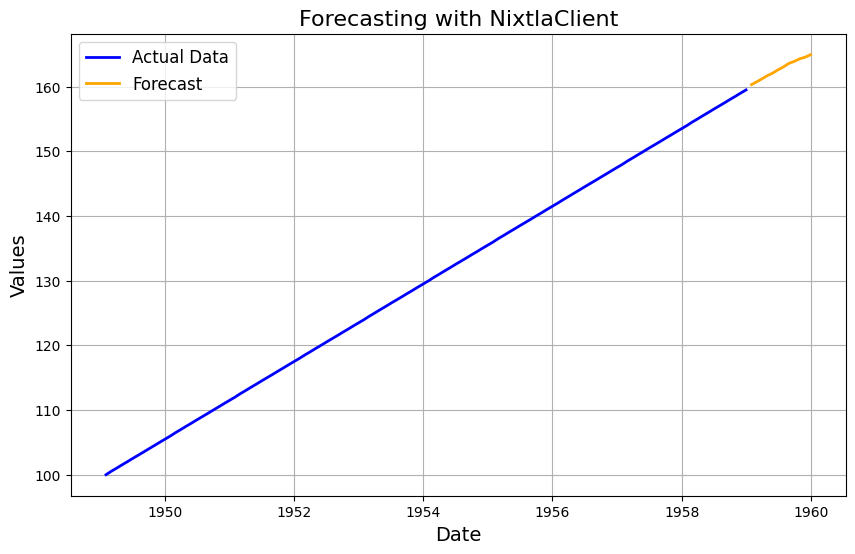

In [31]:


# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from nixtlats import TimeGPT
from nixtlats import NixtlaClient

# Load Example Time Series Data
# You can replace this URL with your own dataset if available
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')

# Display Data
print("Sample data:")
print(data.head())

# Plot the Original Data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
plt.title('Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Preprocess Data for Multivariate Forecasting
# For demonstration, let's create synthetic multivariate data
data['Passengers_Scaled'] = data['Passengers'] / 1000
data['Trend'] = data['Passengers'].rolling(window=12, min_periods=1).mean()
print("Processed data sample:")
print(data.head())

# Instantiate NixtlaClient
client = NixtlaClient(api_key="nixak-G2WzVRyCuCb6zURfeM3aftmTaLEn1Uu7eL82BSauIt59ujrAogtX93E67ExiZxVy4m62dNLjVtbuKqgT")

# Prepare Input Data
data = pd.DataFrame({
    "ds": pd.date_range(start="1949-01-01", periods=12 * 10, freq="ME"),  # Use 'ME' for month-end
    "y": [100 + x * 0.5 for x in range(12 * 10)]  # Example values
})

# Ensure 'ds' is in datetime format
data["ds"] = pd.to_datetime(data["ds"])

# Set Forecasting Parameters
forecast_horizon = 12  # Forecast for 12 steps (months)
frequency = "M"  # Monthly frequency (this parameter is valid for NixtlaClient)

# Perform Forecasting
results = client.forecast(
    df=data,
    h=forecast_horizon,
    freq=frequency,
    id_col="unique_id",  # Optional if multiple series are included
    time_col="ds",
    target_col="y"
)

# Ensure 'ds' in results is in datetime format
results["ds"] = pd.to_datetime(results["ds"])

# Plot Results with Larger Figure
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(data["ds"], data["y"], label="Actual Data", color="blue", linewidth=2)
plt.plot(results["ds"], results["TimeGPT"], label="Forecast", color="orange", linewidth=2)
plt.title("Forecasting with NixtlaClient", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()


#Fine-Tuning TimeGPT

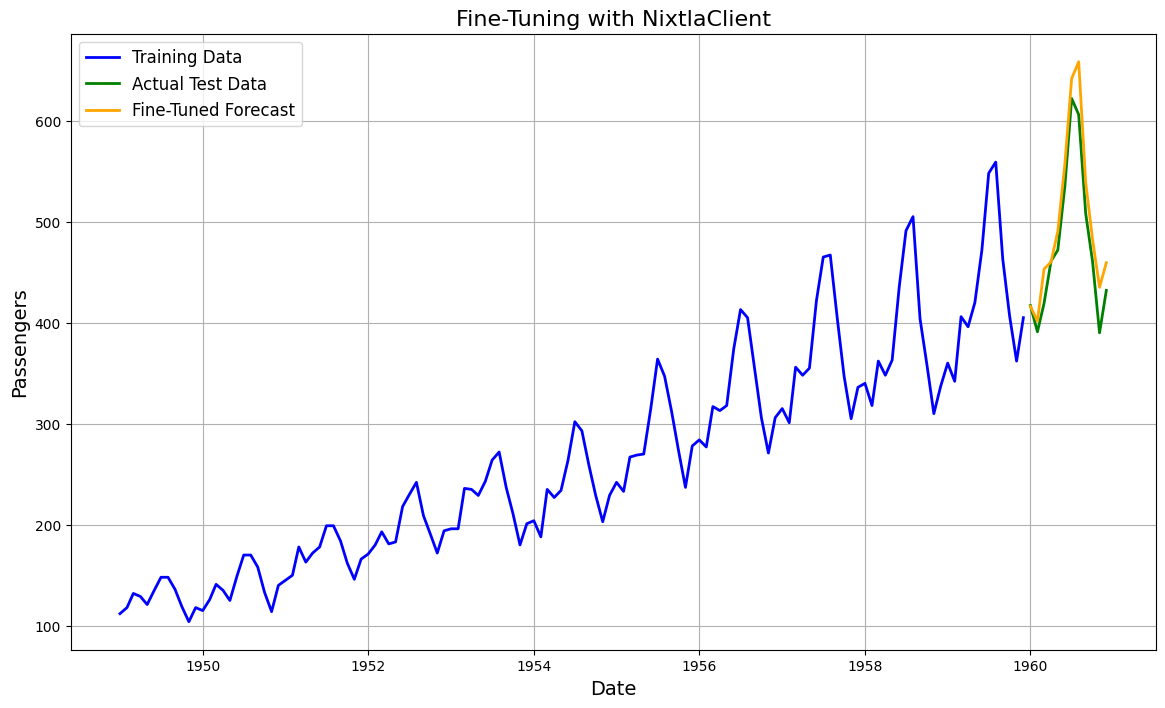

In [32]:


# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from nixtlats import TimeGPT

# Load Dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)
data['Month'] = pd.to_datetime(data['Month'])
data = data.rename(columns={"Month": "ds", "Passengers": "y"})  # Rename columns to match Nixtla's format

# Train-Test Split
train = data.iloc[:-12]  # All but the last 12 months
test = data.iloc[-12:]  # Last 12 months

# Fine-Tune and Forecast
forecast_horizon = 12  # Forecast for 12 months
results = client.forecast(
    df=train,
    h=forecast_horizon,
    freq="M",
    time_col="ds",
    target_col="y",
    finetune_steps=12  # Fine-tune using the last 12 data points from training
)

# Ensure 'ds' in results is in datetime format
results["ds"] = pd.to_datetime(results["ds"])

# Plot Results
plt.figure(figsize=(14, 8))
plt.plot(train["ds"], train["y"], label="Training Data", color="blue", linewidth=2)
plt.plot(test["ds"], test["y"], label="Actual Test Data", color="green", linewidth=2)
plt.plot(results["ds"], results["TimeGPT"], label="Fine-Tuned Forecast", color="orange", linewidth=2)
plt.title("Fine-Tuning with NixtlaClient", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Passengers", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


#Anomaly Detection

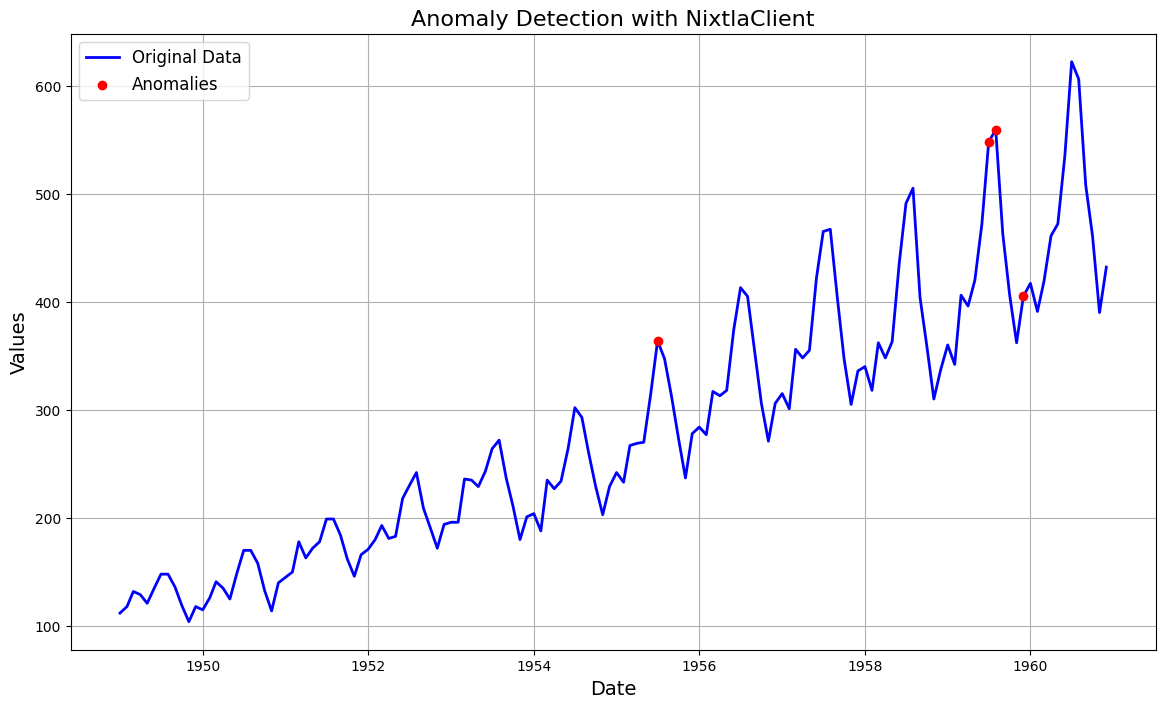

In [34]:

# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from nixtlats import TimeGPT

# Load Dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)
data['Month'] = pd.to_datetime(data['Month'])
data = data.rename(columns={"Month": "ds", "Passengers": "y"})  # Rename columns to match Nixtla's format

# Perform Anomaly Detection
results = client.detect_anomalies(
    df=data,
    freq="M",  # Monthly frequency
    time_col="ds",
    target_col="y",
    level=99  # Confidence level for anomaly detection
)

# Ensure 'ds' in results is in datetime format
results["ds"] = pd.to_datetime(results["ds"])

# Merge Results with Original Data
merged = pd.merge(data, results, on="ds", how="left")

# Plot Results with Anomalies Highlighted
plt.figure(figsize=(14, 8))
plt.plot(data["ds"], data["y"], label="Original Data", color="blue", linewidth=2)
anomalies = merged[merged["anomaly"] == 1]  # Filter anomalies
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomalies", zorder=5)
plt.title("Anomaly Detection with NixtlaClient", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

#Energy Forecasting

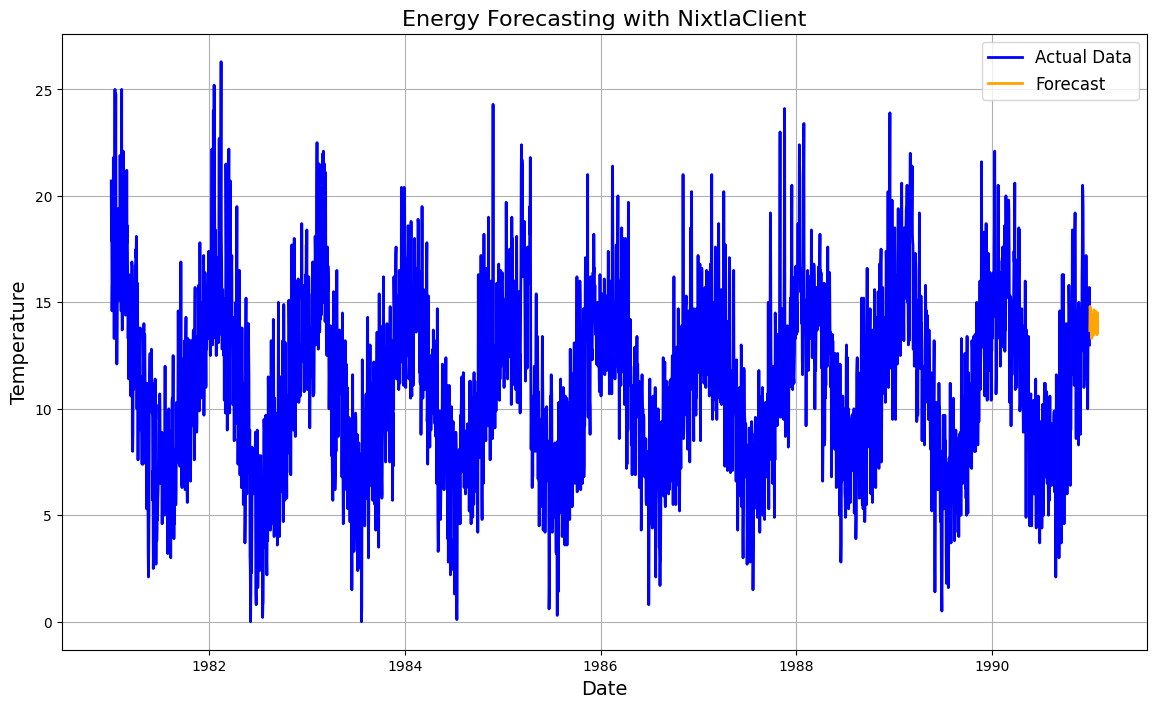

In [36]:


# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from nixtlats import TimeGPT

# Load Energy Dataset (Synthetic Example)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url)
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "Temp": "y"})  # Rename columns to match Nixtla's expected format

# Set Forecasting Parameters
forecast_horizon = 30  # Forecast for 30 days
frequency = "D"  # Daily frequency

# Perform Forecasting
results = client.forecast(
    df=data,
    h=forecast_horizon,
    freq=frequency,
    time_col="ds",
    target_col="y"
)

# Ensure 'ds' in results is in datetime format
results["ds"] = pd.to_datetime(results["ds"])

# Plot Results
plt.figure(figsize=(14, 8))
plt.plot(data["ds"], data["y"], label="Actual Data", color="blue", linewidth=2)
plt.plot(results["ds"], results["TimeGPT"], label="Forecast", color="orange", linewidth=2)
plt.title("Energy Forecasting with NixtlaClient", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


#Bitcoin Price Forecasting

In [40]:
!pip install nixtlats matplotlib yfinance


[*********************100%***********************]  1 of 1 completed


          ds            y
0 2020-01-01  7194.892090
1 2020-01-02  7202.551270
2 2020-01-03  6984.428711
3 2020-01-04  7345.375488
4 2020-01-05  7410.451660


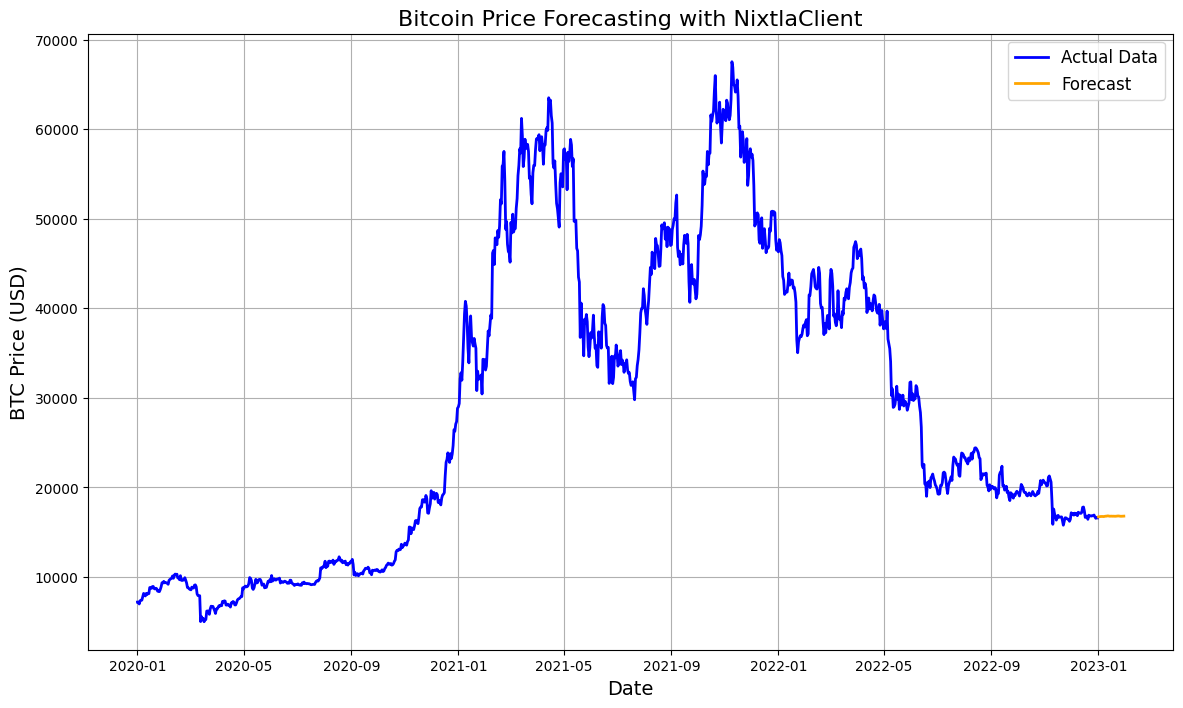

In [48]:


# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from nixtlats import TimeGPT
import yfinance as yf

# Load Bitcoin Price Data
btc = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01', interval='1d')
btc.reset_index(inplace=True)

# Manually Rename Columns for Compatibility
btc.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Use 'Adj Close' or 'Close' for the Target Variable
if "Adj Close" in btc.columns:
    btc = btc.rename(columns={"Adj Close": "y"})
elif "Close" in btc.columns:
    btc = btc.rename(columns={"Close": "y"})
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in the DataFrame.")

# Ensure 'ds' and 'y' Columns Are Valid
btc["ds"] = pd.to_datetime(btc["Date"])  # Ensure 'ds' is datetime
btc["y"] = pd.to_numeric(btc["y"], errors="coerce")  # Ensure 'y' is numeric
btc = btc.dropna(subset=["y"])  # Drop rows with NaN values in 'y'

# Clean the DataFrame
btc = btc[["ds", "y"]].drop_duplicates()  # Keep only 'ds' and 'y'
btc = btc.sort_values(by="ds")  # Ensure chronological order

# Debug: Inspect Cleaned Data
print(btc.head())

# Set Forecasting Parameters
forecast_horizon = 30  # Forecast for 30 days
frequency = "D"  # Daily frequency

# Perform Forecasting
results = client.forecast(
    df=btc,
    h=forecast_horizon,
    freq=frequency,
    time_col="ds",
    target_col="y"
)

# Ensure 'ds' in results is in datetime format
results["ds"] = pd.to_datetime(results["ds"])

# Plot Results
plt.figure(figsize=(14, 8))
plt.plot(btc["ds"], btc["y"], label="Actual Data", color="blue", linewidth=2)
plt.plot(results["ds"], results["TimeGPT"], label="Forecast", color="orange", linewidth=2)
plt.title("Bitcoin Price Forecasting with NixtlaClient", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("BTC Price (USD)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [47]:
print(btc.columns)


Index(['BTC-USD', 'BTC-USD', 'BTC-USD', 'BTC-USD', 'BTC-USD', 'BTC-USD', 'ds'], dtype='object')
